In [1]:
import sys
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
os.chdir('..')

## Reading and preparing time

In [3]:
FILE = 'data/raw/soc-sign-bitcoinotc.csv'
COLUMNS = [
    'source',
    'target',
    'rating',
    'timestamp',
]

data = pd.read_csv(FILE, names=COLUMNS)
data['datetime'] = data['timestamp'].apply(datetime.fromtimestamp)
print(data.shape)
data.head()

(35592, 5)


,source,target,rating,timestamp,datetime
0,6,2,4,1.289242e+09,2010-11-08 16:45:11.728360
1,6,5,2,1.289242e+09,2010-11-08 16:45:41.533780
2,1,15,1,1.289243e+09,2010-11-08 17:05:40.390490
3,4,3,7,1.289245e+09,2010-11-08 17:41:17.369750
4,13,16,8,1.289254e+09,2010-11-08 20:10:54.447460


## Basic stats

In [4]:
data['source'].describe()

count    35592.000000
mean      2353.847269
std       1605.771178
min          1.000000
25%        988.000000
50%       2125.000000
75%       3722.000000
max       6000.000000
Name: source, dtype: float64

In [5]:
data['target'].describe()

count    35592.000000
mean      2417.478254
std       1658.232170
min          1.000000
25%        978.000000
50%       2178.000000
75%       3804.000000
max       6005.000000
Name: target, dtype: float64

In [6]:
pd.concat([data['source'], data['target']]).nunique()

5881

In [7]:
data['datetime'].describe()

count                          35592
unique                         35592
top       2011-06-10 01:45:39.187580
freq                               1
first     2010-11-08 16:45:11.728360
last      2016-01-24 23:12:03.757280
Name: datetime, dtype: object

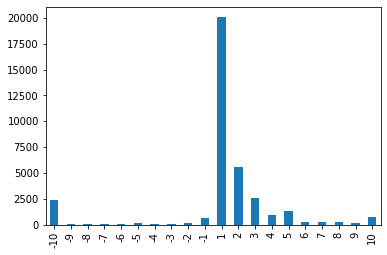

In [8]:
data['rating'].value_counts().sort_index().plot(kind='bar')

## Separating data in time

I want to separate the data in two:
  
  1. The transaction data, the graph that will be used for training
  2. The label data.
  
They are splitted in time, the transactions in 1. will be used to infer the label in the future data (2.).

Here I make choice close to the 60% of data as transactions.

In [9]:
data['datetime_decile'] = pd.qcut(data['datetime'], 10, labels=False)
data.groupby('datetime_decile')['datetime'].max()

datetime_decile
0   2011-06-04 09:40:15.375910
1   2011-10-26 02:23:10.794050
2   2012-06-06 20:31:33.957610
3   2012-09-30 10:13:11.422800
4   2013-01-16 22:31:06.345590
5   2013-04-13 14:25:27.051470
6   2013-07-19 08:24:16.020160
7   2013-10-25 14:44:05.444880
8   2014-04-24 08:40:22.692600
9   2016-01-24 23:12:03.757280
Name: datetime, dtype: datetime64[ns]

In [10]:
datetime_split = datetime(2013, 4, 14)
transaction_data = data.loc[data['datetime'] < datetime_split, :]
eval_data = data.loc[data['datetime'] >= datetime_split, :]

## Labeling transactions

As of the article, it is understood that:
  
  1. A rating 1 is neutral
  2. A negative rating is negative
  3. A rating bigger than 1 in positive. 
  
This will be sumarize in the node level.

/home/caiolmart/.local/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/caiolmart/.local/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


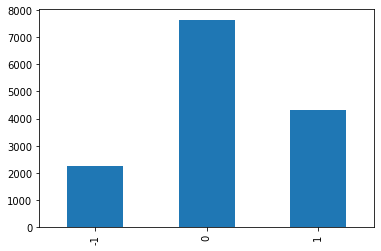

In [11]:
def is_transaction_trustworthy(rating: int):
    if rating > 1:
        return 1
    elif rating < 0:
        return -1
    return 0

eval_data.loc[:, 'transaction_label'] = eval_data.loc[:, 'rating'].apply(is_transaction_trustworthy)
eval_data['transaction_label'].value_counts().sort_index().plot(kind='bar')

## Labeling nodes

The summarization is as follows:

  1. A node (target) with a negative rating from some user is considered risky.
  2. A node with more than half of the transactions pointed to it as positive is considered trustworthy.
  3. Unknown otherwise.

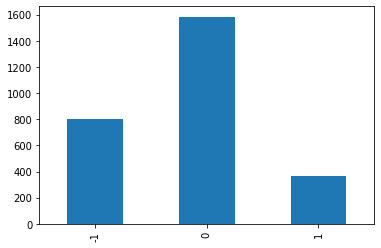

In [12]:
def node_label(target_data: pd.DataFrame):
    if target_data['transaction_label'].min() < 0:
        return -1
    elif target_data['transaction_label'].sum() > target_data.shape[0] / 2:
        return 1
    return 0

node_labels = eval_data.groupby('target').apply(node_label)
node_labels.value_counts().sort_index().plot(kind='bar')

In [13]:
node_labels.value_counts().sort_index() / node_labels.shape[0]

-1    0.291379
 0    0.576210
 1    0.132412
dtype: float64

#### Number of labeled nodes

In [14]:
node_labels.shape[0]

2749

In [15]:
mask = transaction_data['target'].isin(node_labels.index.unique())
transaction_data[mask]['target'].nunique()

786

## Choosing the datetime split

With my personal choice of time split I reached 2749 noded labels, but only 786 of those were in the transactions data. 

In the article it is mentioned that there were 1447 users, 5739 rating records and 20% risky nodes.

I will try other time splits to reach these numbers.

In [16]:
n_splits = 20
quantiles = np.linspace(1 / n_splits, 1 - 1 / n_splits, n_splits - 1)
quantiles

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [17]:
splits = data['datetime'].quantile(quantiles)
splits

0.05   2011-05-09 15:39:48.732656896
0.10   2011-06-04 09:40:29.566855936
0.15   2011-06-23 21:09:29.485234432
0.20   2011-10-26 03:12:33.652766208
0.25   2012-03-08 18:47:10.083377408
0.30   2012-06-06 21:09:36.595443968
0.35   2012-08-11 00:01:22.640125952
0.40   2012-09-30 10:13:15.503064064
0.45   2012-11-22 03:18:39.051611136
0.50   2013-01-16 23:06:14.492320000
0.55   2013-03-15 16:39:21.445050368
0.60   2013-04-13 14:27:25.422212096
0.65   2013-05-24 19:29:57.333050368
0.70   2013-07-19 08:24:19.238752768
0.75   2013-08-15 17:29:16.842030080
0.80   2013-10-25 15:10:27.428704000
0.85   2013-12-29 02:02:31.381174016
0.90   2014-04-24 08:42:37.122477056
0.95   2014-09-16 17:34:41.093910528
Name: datetime, dtype: datetime64[ns]

In [18]:
n_labels = []
feature_nodes = []
n_trainable_nodes = []

for split in splits:
    # Spliting data
    transaction_data = data.loc[data['datetime'] < split, :]
    eval_data = data.loc[data['datetime'] >= split, :]
    
    # Number of labelled nodes
    eval_data.loc[:, 'transaction_label'] = eval_data.loc[:, 'rating'].apply(is_transaction_trustworthy)
    node_labels = eval_data.groupby('target').apply(node_label)
    n_labels.append(node_labels.shape[0])
    
    # Number of feature nodes
    feature_nodes.append(transaction_data['target'].nunique())
    
    # Number of trainable nodes - Nodes that appear in both transaction and labelling data
    mask = transaction_data['target'].isin(node_labels.index)
    n_trainable_nodes.append(transaction_data[mask]['target'].nunique())

In [19]:
max(n_trainable_nodes)

788

In [20]:
splits.iloc[np.argmax(n_trainable_nodes)]

Timestamp('2013-04-13 14:27:25.422212096')

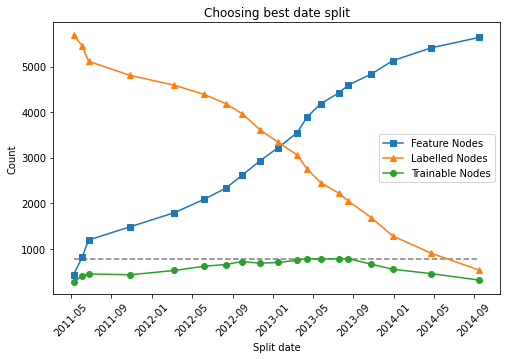

In [21]:
plt.figure(figsize=(8, 5))
plt.title('Choosing best date split')
plt.plot(splits, feature_nodes, label='Feature Nodes', marker='s')
plt.plot(splits, n_labels, label='Labelled Nodes', marker='^')
plt.plot(splits, n_trainable_nodes, label='Trainable Nodes', marker='o')


plt.hlines(max(n_trainable_nodes), 
           splits.iloc[0], 
           splits.iloc[-1],
           ls='--',
           alpha=0.5,
           color='black')
plt.xticks(rotation=45)
plt.xlabel('Split date')
plt.ylabel('Count')
plt.legend()

## Conclusion

I could not reach the paper numbers. The best split I found give me 788 trainable data points. Which is quite few.